In [3]:
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from os import path
import os
import sys
import random
import math
import matplotlib.image as mpimg
import requests
import api_helper
import sqlite3
import numpy as np

In [ ]:
BASE_URL = 'https://api-web.nhle.com/v1/'
def url(end): return path.join(BASE_URL, end)
def pbp_url(gameid): return f"gamecenter/{gameid}/play-by-play"
def season_url(team, season): return f"club-schedule-season/{team}/{season}"
def game_log_url(player, season, game_type): return f"player/{player}/game-log/{season}/{game_type}"
shot_types = ["shot-on-goal", "blocked-shot", "missed-shot", "goal"]
def shift_chart_url(gameid): return f"https://api.nhle.com/stats/rest/en/shiftcharts?cayenneExp=gameId={gameid}&limit=-1"
def player_url(player_id): return f"https://api-web.nhle.com/v1/player/{player_id}/landing"


In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [6]:
all_games = requests.get("https://api.nhle.com/stats/rest/en/game").json()

In [7]:
all_games["data"]

[{'id': 1917020001,
  'easternStartTime': '1917-12-19T20:00:00',
  'gameDate': '1917-12-19',
  'gameNumber': 1,
  'gameScheduleStateId': 1,
  'gameStateId': 7,
  'gameType': 2,
  'homeScore': 4,
  'homeTeamId': 36,
  'period': 3,
  'season': 19171918,
  'visitingScore': 7,
  'visitingTeamId': 8},
 {'id': 1917020002,
  'easternStartTime': '1917-12-19T20:00:00',
  'gameDate': '1917-12-19',
  'gameNumber': 2,
  'gameScheduleStateId': 1,
  'gameStateId': 7,
  'gameType': 2,
  'homeScore': 10,
  'homeTeamId': 41,
  'period': 3,
  'season': 19171918,
  'visitingScore': 9,
  'visitingTeamId': 57},
 {'id': 1917020003,
  'easternStartTime': '1917-12-22T20:00:00',
  'gameDate': '1917-12-22',
  'gameNumber': 3,
  'gameScheduleStateId': 1,
  'gameStateId': 7,
  'gameType': 2,
  'homeScore': 11,
  'homeTeamId': 57,
  'period': 3,
  'season': 19171918,
  'visitingScore': 4,
  'visitingTeamId': 36},
 {'id': 1917020004,
  'easternStartTime': '1917-12-22T20:00:00',
  'gameDate': '1917-12-22',
  'gameNu

In [8]:
conn = sqlite3.connect("./db/game-data.sqlite")

In [10]:
all_recent_regular = pd.read_sql("""SELECT * FROM games_basic WHERE season >= 20002001 AND gameType=2""", conn)

In [11]:
all_recent_regular.head()

,index,id,easternStartTime,gameDate,gameNumber,gameScheduleStateId,gameStateId,gameType,homeScore,homeTeamId,period,season,visitingScore,visitingTeamId,hasPBP
0,38196,2000020001,2000-10-04T19:00:00,2000-10-04,1,1,7,2,2,25,4.0,20002001,2,21,1
1,38197,2000020002,2000-10-05T19:00:00,2000-10-05,2,1,7,2,4,6,4.0,20002001,4,9,1
2,38198,2000020003,2000-10-05T19:00:00,2000-10-05,3,1,7,2,4,7,3.0,20002001,2,16,1
3,38199,2000020004,2000-10-05T19:00:00,2000-10-05,4,1,7,2,6,4,3.0,20002001,3,23,1
4,38200,2000020005,2000-10-05T19:00:00,2000-10-05,5,1,7,2,3,20,3.0,20002001,4,17,1


In [114]:
to_drop = ["details.discreteClip", "pptReplayUrl", "details.highlightClipSharingUrl", "details.highlightClip", "details.highlightClipSharingUrlFr", "details.highlightClipFr", "details.discreteClipFr"]

In [115]:
def fetch_and_save_pbp(gameid):
    data = requests.get(url(pbp_url(gameid)))
    if data.status_code == 404:
        conn.execute(f"UPDATE games_basic SET hasPBP = 0 WHERE id={gameid}")
        print(404)
        return
    data = data.json()
    if len(data["plays"]) == 0:
        conn.execute(f"UPDATE games_basic SET hasPBP = 0 WHERE id={gameid}")
    data = pd.json_normalize(data["plays"])
    will_drop = [x for x in to_drop if x in data.columns]
    data = data.drop(will_drop, axis=1)
    data["gameid"] = gameid
    data.to_sql("events", conn, index=False, if_exists="append")
    return data

In [100]:
d = fetch_and_save_pbp(2000020002)

In [10]:
ids = conn.execute("SELECT id FROM games_basic").fetchall()

In [13]:
ids = [x[0] for x in ids]

In [117]:
existing_ids = [x[0] for x in conn.execute("SELECT DISTINCT events.gameid FROM events")]
no_pbp = [x[0] for x in conn.execute("SELECT id FROM games_basic WHERE hasPBP = 0")]
print("starting", existing_ids)
for id in ids:
    if id in existing_ids or id in no_pbp: continue
    try:
        fetch_and_save_pbp(id)
    except Exception as e:
        print(e)
        print(id)
        break


starting [2000020001, 2000020002, 1917020001, 1917020002, 1917020003, 1917020004, 1917020005, 1917020006, 1917020007, 1917020008, 1917020009, 1917020010, 1917020011, 1917020012, 1917020013, 1917020014, 1917020015, 1917020016, 1917020017, 1917020018, 1917020019, 1917020020, 1917020021, 1917020022, 1917020023, 1917020024, 1917020025, 1917020026, 1917020027, 1917020028, 1917020029, 1917020030, 1917020031, 1917020032, 1917020033, 1917020034, 1917030111, 1917030112, 1917030212, 1917030213, 1917030214, 1917030215, 1918020001, 1918020002, 1918020003, 1918020004, 1918020005, 1918020006, 1918020007, 1918020008, 1918020009, 1918020010, 1918020011, 1918020012, 1918020013, 1918020014, 1918020015, 1918020016, 1918020017, 1918020018, 1918020019, 1918020020, 1918020021, 1918020022, 1918020023, 1918020024, 1918020025, 1918020026, 1918020027, 1918030111, 1918030112, 1918030113, 1918030114, 1918030115, 1918030211, 1918030212, 1918030213, 1918030214, 1918030215, 1919020001, 1919020002, 1919020003, 191902

In [7]:
conn = sqlite3.connect("./db/game-data.sqlite")

In [ ]:
teams = requests.get("https://api.nhle.com/stats/rest/en/team").json()


In [126]:
print(teams)

{'data': [{'id': 32, 'franchiseId': 27, 'fullName': 'Quebec Nordiques', 'leagueId': 133, 'rawTricode': 'QUE', 'triCode': 'QUE'}, {'id': 8, 'franchiseId': 1, 'fullName': 'Montréal Canadiens', 'leagueId': 133, 'rawTricode': 'MTL', 'triCode': 'MTL'}, {'id': 58, 'franchiseId': 5, 'fullName': 'Toronto St. Patricks', 'leagueId': 133, 'rawTricode': 'TSP', 'triCode': 'TSP'}, {'id': 7, 'franchiseId': 19, 'fullName': 'Buffalo Sabres', 'leagueId': 133, 'rawTricode': 'BUF', 'triCode': 'BUF'}, {'id': 46, 'franchiseId': 13, 'fullName': 'Oakland Seals', 'leagueId': 133, 'rawTricode': 'OAK', 'triCode': 'OAK'}, {'id': 48, 'franchiseId': 23, 'fullName': 'Kansas City Scouts', 'leagueId': 133, 'rawTricode': 'KCS', 'triCode': 'KCS'}, {'id': 2, 'franchiseId': 22, 'fullName': 'New York Islanders', 'leagueId': 133, 'rawTricode': 'NYI', 'triCode': 'NYI'}, {'id': 36, 'franchiseId': 3, 'fullName': 'Ottawa Senators (1917)', 'leagueId': 133, 'rawTricode': 'SEN', 'triCode': 'SEN'}, {'id': 70, 'franchiseId': None, '

In [127]:
teams_df = pd.DataFrame(teams["data"])

In [131]:
mcdavid_games = requests.get("https://api.nhle.com/stats/rest/en/skater/summary?isGame=true&cayenneExp=skaterFullName=%22Connor%20McDavid%22&limit=-1").json()

In [134]:
md_games_df = pd.DataFrame(mcdavid_games["data"])

In [143]:
md_games_df["season"] = md_games_df["gameId"].apply(lambda id: str(id)[0:4])

In [170]:
md_toi = md_games_df.groupby(['season'], as_index=False)["timeOnIcePerGame"].mean()
md_toi.head(20)

,season,timeOnIcePerGame
0,2015,1133.088889
1,2016,1278.389474
2,2017,1293.097561
3,2018,1370.230769
4,2019,1313.779412
5,2020,1362.216667
6,2021,1333.666667
7,2022,1353.351064
8,2023,1306.396040
9,2024,1328.047619


In [155]:
md_games_df["gameDate"] = pd.to_datetime(md_games_df["gameDate"])

In [160]:
md_games_df["gameDate"]

0     2016-10-30
1     2023-03-18
2     2015-10-13
3     2018-01-06
4     2019-11-24
5     2025-01-04
6     2023-11-11
7     2023-04-25
8     2017-03-22
9     2024-04-15
10    2019-11-04
11    2023-02-25
12    2024-05-01
13    2021-01-18
14    2018-12-07
15    2017-10-09
16    2017-11-05
17    2016-12-09
18    2015-11-03
19    2021-02-02
20    2021-11-05
21    2019-02-03
22    2017-11-14
23    2024-12-14
24    2022-03-03
25    2025-01-03
26    2015-10-27
27    2019-03-04
28    2018-10-30
29    2021-01-14
30    2016-11-15
31    2015-10-21
32    2015-10-08
33    2023-12-08
34    2018-10-28
35    2018-11-01
36    2018-12-22
37    2022-12-23
38    2024-12-10
39    2018-12-09
40    2017-03-18
41    2024-11-09
42    2023-03-25
43    2016-03-24
44    2019-01-16
45    2022-10-18
46    2023-10-29
47    2016-03-06
48    2024-10-28
49    2024-02-28
50    2022-11-01
51    2023-01-09
52    2022-11-03
53    2019-03-11
54    2024-03-09
55    2018-02-15
56    2018-02-05
57    2019-12-04
58    2024-01-

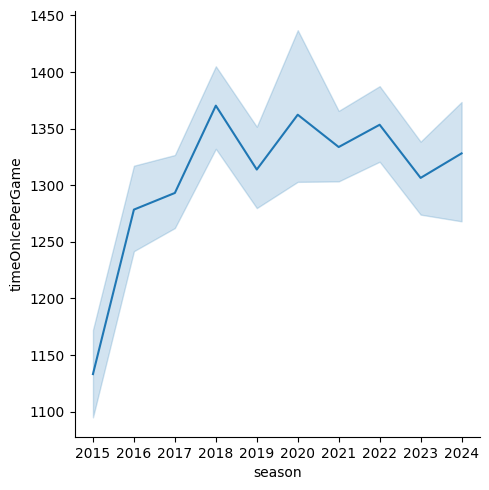

In [173]:
g = sns.relplot(data=md_games_df.sort_values("season", ascending=True), kind="line", x="season", y="timeOnIcePerGame", facet_kws=dict())

In [175]:
ids

[1917020001,
 1917020002,
 1917020003,
 1917020004,
 1917020005,
 1917020006,
 1917020007,
 1917020008,
 1917020009,
 1917020010,
 1917020011,
 1917020012,
 1917020013,
 1917020014,
 1917020015,
 1917020016,
 1917020017,
 1917020018,
 1917020019,
 1917020020,
 1917020021,
 1917020022,
 1917020023,
 1917020024,
 1917020025,
 1917020026,
 1917020027,
 1917020028,
 1917020029,
 1917020030,
 1917020031,
 1917020032,
 1917020033,
 1917020034,
 1917020035,
 1917020036,
 1917030111,
 1917030112,
 1917030211,
 1917030212,
 1917030213,
 1917030214,
 1917030215,
 1918020001,
 1918020002,
 1918020003,
 1918020004,
 1918020005,
 1918020006,
 1918020007,
 1918020008,
 1918020009,
 1918020010,
 1918020011,
 1918020012,
 1918020013,
 1918020014,
 1918020015,
 1918020016,
 1918020017,
 1918020018,
 1918020019,
 1918020020,
 1918020021,
 1918020022,
 1918020023,
 1918020024,
 1918020025,
 1918020026,
 1918020027,
 1918030111,
 1918030112,
 1918030113,
 1918030114,
 1918030115,
 1918030211,
 1918030212,

In [176]:
seasons = requests.get("https://api-web.nhle.com/v1/season").json()

In [178]:
seasons = list(reversed(seasons))
print(seasons)

[20242025, 20232024, 20222023, 20212022, 20202021, 20192020, 20182019, 20172018, 20162017, 20152016, 20142015, 20132014, 20122013, 20112012, 20102011, 20092010, 20082009, 20072008, 20062007, 20052006, 20032004, 20022003, 20012002, 20002001, 19992000, 19981999, 19971998, 19961997, 19951996, 19941995, 19931994, 19921993, 19911992, 19901991, 19891990, 19881989, 19871988, 19861987, 19851986, 19841985, 19831984, 19821983, 19811982, 19801981, 19791980, 19781979, 19771978, 19761977, 19751976, 19741975, 19731974, 19721973, 19711972, 19701971, 19691970, 19681969, 19671968, 19661967, 19651966, 19641965, 19631964, 19621963, 19611962, 19601961, 19591960, 19581959, 19571958, 19561957, 19551956, 19541955, 19531954, 19521953, 19511952, 19501951, 19491950, 19481949, 19471948, 19461947, 19451946, 19441945, 19431944, 19421943, 19411942, 19401941, 19391940, 19381939, 19371938, 19361937, 19351936, 19341935, 19331934, 19321933, 19311932, 19301931, 19291930, 19281929, 19271928, 19261927, 19251926, 19241925,

In [193]:
seas = requests.get("https://api.nhle.com/stats/rest/en/skater/summary?isGame=false&cayenneExp=seasonId=2011020201&limit=-1").json()["data"]

In [194]:
seas_df = pd.DataFrame(seas)

In [231]:
story = requests.get(shift_chart_url(2010020001))

In [222]:
game_ids = conn.execute("SELECT id FROM games_basic WHERE season>=20102011 AND season <=20232024 AND (gameType = 2 OR gameType=3)")

In [223]:
game_ids = game_ids.fetchall()

In [224]:
game_ids = [x[0] for x in game_ids]

In [228]:
game_ids[0]

2010020001

In [252]:
story = requests.get(shift_chart_url(2018020419))

In [253]:
test = pd.DataFrame(story.json()["data"])

In [254]:
test.head(10)

,id,detailCode,duration,endTime,eventDescription,eventDetails,eventNumber,firstName,gameId,hexValue,lastName,period,playerId,shiftNumber,startTime,teamAbbrev,teamId,teamName,typeCode
0,8627887,803,None,06:52,EVG,"Tanner Pearson, Patric Hornqvist",72,Evgeni,2018020419,#FFB81C,Malkin,1,8471215,0,06:52,PIT,5,Pittsburgh Penguins,505
1,8627104,0,00:43,01:31,None,None,102,Evgeni,2018020419,#FFB81C,Malkin,1,8471215,1,00:48,PIT,5,Pittsburgh Penguins,517
2,8627105,0,00:48,04:09,None,None,109,Evgeni,2018020419,#FFB81C,Malkin,1,8471215,2,03:21,PIT,5,Pittsburgh Penguins,517
3,8627106,0,00:19,06:52,None,None,117,Evgeni,2018020419,#FFB81C,Malkin,1,8471215,3,06:33,PIT,5,Pittsburgh Penguins,517
4,8627107,0,00:48,09:16,None,None,121,Evgeni,2018020419,#FFB81C,Malkin,1,8471215,4,08:28,PIT,5,Pittsburgh Penguins,517
5,8627108,0,01:00,11:47,None,None,128,Evgeni,2018020419,#FFB81C,Malkin,1,8471215,5,10:47,PIT,5,Pittsburgh Penguins,517
6,8627109,0,01:01,16:33,None,None,140,Evgeni,2018020419,#FFB81C,Malkin,1,8471215,6,15:32,PIT,5,Pittsburgh Penguins,517
7,8627110,0,00:53,18:45,None,None,148,Evgeni,2018020419,#FFB81C,Malkin,1,8471215,7,17:52,PIT,5,Pittsburgh Penguins,517
8,8627111,0,00:16,20:00,None,None,353,Evgeni,2018020419,#FFB81C,Malkin,1,8471215,8,19:44,PIT,5,Pittsburgh Penguins,517
9,8629467,0,00:35,01:25,None,None,356,Evgeni,2018020419,#FFB81C,Malkin,2,8471215,9,00:50,PIT,5,Pittsburgh Penguins,517


In [ ]:
to_drop = []
def fetch_and_save_shifts(gameid):
    data = requests.get(shift_chart_url(gameid))
    if data.status_code == 404:
        conn.execute(f"UPDATE games_basic SET hasShifts = 0 WHERE id={gameid}")
        print(404)
        return
    data = data.json()
    if len(data["data"]) == 0:
        conn.execute(f"UPDATE games_basic SET hasShifts = 0 WHERE id={gameid}")
        return
    data = pd.DataFrame(data["data"])
    #will_drop = [x for x in to_drop if x in data.columns]
    #data = data.drop(will_drop, axis=1)
    data.to_sql("shifts", conn, index=False, if_exists="append")
    return data

In [270]:
existing_ids = [x[0] for x in conn.execute("SELECT DISTINCT gameId FROM shifts")]
no_shifts = [x[0] for x in conn.execute("SELECT id FROM games_basic WHERE hasShifts = 0")]
for id in game_ids:
    if id in existing_ids or id in no_shifts: continue
    print(id)
    fetch_and_save_shifts(id)


In [8]:
fenwicks = pd.read_sql("SELECT * FROM FenwickAndScore", conn)

In [9]:
oilers = fenwicks.loc[fenwicks.TeamId == 22]

In [10]:
oilers["season"] = oilers["gameid"].apply(lambda id: math.floor(id / 1_000_000))

/var/folders/3_/qlydfz1165v__z4jwp9tb0t00000gn/T/ipykernel_38907/2439856252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oilers["season"] = oilers["gameid"].apply(lambda id: math.floor(id / 1_000_000))


In [11]:
fenwicks["season"] = fenwicks["gameid"].apply(lambda id: math.floor(id / 1_000_000))

In [12]:
fenwicks["fenwickPct"] = fenwicks.AdjustedFenwickFor / (fenwicks.AdjustedFenwickFor + fenwicks.AdjustedFenwickAgainst)

In [13]:
fenwicks.head()

,gameid,TeamId,TeamName,AdjustedFenwickFor,RawFenwickFor,isHomeTeam,OpponentId,OpponentName,AdjustedFenwickAgainst,RawFenwickAgainst,ScoreFor,ScoreAgainst,season,fenwickPct
0,2010020001,8,Montréal Canadiens,28.992240,30,0,10,Toronto Maple Leafs,27.680428,27,2,3,2010,0.511574
1,2010020001,10,Toronto Maple Leafs,27.680428,27,1,8,Montréal Canadiens,28.992240,30,3,2,2010,0.488426
2,2010020002,4,Philadelphia Flyers,30.865375,29,0,5,Pittsburgh Penguins,34.908733,37,3,2,2010,0.469263
3,2010020002,5,Pittsburgh Penguins,34.908733,37,1,4,Philadelphia Flyers,30.865375,29,2,3,2010,0.530737
4,2010020003,12,Carolina Hurricanes,37.900863,36,0,30,Minnesota Wild,24.733733,26,4,3,2010,0.605111


In [286]:
oilers.head()

,gameid,TeamId,TeamName,AdjustedFenwickFor,RawFenwickFor,isHomeTeam,OpponentId,OpponentName,AdjustedFenwickAgainst,RawFenwickAgainst,ScoreFor,ScoreAgainst,season
9,2010020005,22,Edmonton Oilers,28.975373,28,1,20,Calgary Flames,42.158571,44,4,0,2010
51,2010020026,22,Edmonton Oilers,18.363156,18,1,13,Florida Panthers,41.220762,42,3,2,2010
88,2010020045,22,Edmonton Oilers,18.737328,19,0,30,Minnesota Wild,24.548517,24,2,4,2010
129,2010020065,22,Edmonton Oilers,31.420537,30,0,20,Calgary Flames,41.955768,44,3,4,2010
180,2010020091,22,Edmonton Oilers,33.065109,37,1,30,Minnesota Wild,30.722295,28,2,4,2010


In [289]:
oilers_agg = oilers.groupby("season").aggregate(
    avgAdjFenwickFor=("AdjustedFenwickFor", "mean"),
    avgAdjFenwickAgainst=("AdjustedFenwickAgainst", "mean"),
    avgGoalsFor=("ScoreFor", "mean"),
    avgGoalsAgainst=("ScoreAgainst", "mean")
)
oilers_agg["avgFenwickPct"] = oilers_agg["avgAdjFenwickFor"] / ( oilers_agg["avgAdjFenwickFor"] + oilers_agg["avgAdjFenwickAgainst"])
oilers_agg["avgFenwickDiff"] = oilers_agg["avgAdjFenwickFor"] - oilers_agg["avgAdjFenwickAgainst"]
oilers_agg["avgGoalPct"] = oilers_agg["avgGoalsFor"] / ( oilers_agg["avgGoalsFor"] + oilers_agg["avgGoalsAgainst"])
oilers_agg["avgGoalDiff"] = oilers_agg["avgGoalsFor"] - oilers_agg["avgGoalsAgainst"]
oilers_agg

,avgAdjFenwickFor,avgAdjFenwickAgainst,avgGoalsFor,avgGoalsAgainst,avgFenwickPct,avgFenwickDiff,avgGoalPct,avgGoalDiff
season,,,,,,,,
2010,27.071356,33.353873,2.146341,2.853659,0.448014,-6.282518,0.429268,-0.707317
2011,29.459445,32.413160,2.304878,2.597561,0.476131,-2.953715,0.470149,-0.292683
2012,28.541682,34.889904,2.229167,2.395833,0.449960,-6.348222,0.481982,-0.166667
2013,27.419135,35.919581,2.121951,2.914634,0.432897,-8.500445,0.421308,-0.792683
2014,30.976136,35.062226,2.231707,3.036585,0.469063,-4.086091,0.423611,-0.804878
2015,31.021251,33.845518,2.134146,2.707317,0.478230,-2.824267,0.440806,-0.573171
2016,33.418224,31.769554,2.756098,2.292683,0.512646,1.648669,0.545894,0.463415
2017,36.488776,35.708821,2.487805,2.975610,0.505402,0.779956,0.455357,-0.487805
2018,31.652289,35.158778,2.475610,3.073171,0.473758,-3.506488,0.446154,-0.597561


In [14]:
seasons = oilers["season"].unique().tolist()
from sklearn.metrics import r2_score
import sklearn
from scipy.stats import linregress

In [15]:
def r_squared(series1, series2):
    slope, intercept, r_value, p_value, std_err = linregress(series1, series2)
    return r_value**2

In [16]:
fenwicks.head()

,gameid,TeamId,TeamName,AdjustedFenwickFor,RawFenwickFor,isHomeTeam,OpponentId,OpponentName,AdjustedFenwickAgainst,RawFenwickAgainst,ScoreFor,ScoreAgainst,season,fenwickPct
0,2010020001,8,Montréal Canadiens,28.992240,30,0,10,Toronto Maple Leafs,27.680428,27,2,3,2010,0.511574
1,2010020001,10,Toronto Maple Leafs,27.680428,27,1,8,Montréal Canadiens,28.992240,30,3,2,2010,0.488426
2,2010020002,4,Philadelphia Flyers,30.865375,29,0,5,Pittsburgh Penguins,34.908733,37,3,2,2010,0.469263
3,2010020002,5,Pittsburgh Penguins,34.908733,37,1,4,Philadelphia Flyers,30.865375,29,2,3,2010,0.530737
4,2010020003,12,Carolina Hurricanes,37.900863,36,0,30,Minnesota Wild,24.733733,26,4,3,2010,0.605111


In [50]:
scorrs = []
for (season, team), group in fenwicks.groupby(["season", "TeamId"]):
    #if season not in (2010, 2011, 2012, 2013, 2014): continue
    season_games = group
    corrs = []
    for i in range(0, 100):
        season_sample = group.sample(n=40)
        season_1 = season_sample.iloc[0:20]
        season_2 = season_sample.iloc[20:40]
        
        dataIn = season_1.AdjustedFenwickFor.mean() - season_1.AdjustedFenwickAgainst.mean()
        dataOut = season_2.ScoreFor.mean() - season_2.ScoreAgainst.mean()#.mean() / (season_2.ScoreFor.mean() + season_2.ScoreAgainst.mean()) # Goals for percentage

        scorrs.append((dataIn, dataOut))

corrs = pd.DataFrame(scorrs)
_, _, r_value, pvalue, _ = linregress(corrs[0], corrs[1])
print(r_value**2, pvalue)

0.2082330054673377 0.0


In [183]:
pids = conn.execute("SELECT * FROM AllPlayerIds")

In [185]:
pids = pids.fetchall()

In [187]:
pids = [x[0] for x in pids]

In [190]:
len(pids)

10156

In [191]:
pdata = requests.get("https://api-web.nhle.com/v1/player/8480069/landing").json()

In [197]:
from pandas import json_normalize

In [202]:
pdata

{'playerId': 8480069,
 'isActive': True,
 'currentTeamId': 21,
 'currentTeamAbbrev': 'COL',
 'fullTeamName': {'default': 'Colorado Avalanche',
  'fr': 'Avalanche du Colorado'},
 'teamCommonName': {'default': 'Avalanche'},
 'teamPlaceNameWithPreposition': {'default': 'Colorado', 'fr': 'du Colorado'},
 'firstName': {'default': 'Cale'},
 'lastName': {'default': 'Makar'},
 'badges': [{'logoUrl': {'default': 'https://assets.nhle.com/badges/4n_face-off.svg',
    'fr': 'https://assets.nhle.com/badges/4n_face-off_fr.svg'},
   'title': {'default': '4 Nations Face-Off',
    'fr': 'Confrontation Des 4 Nations'}}],
 'teamLogo': 'https://assets.nhle.com/logos/nhl/svg/COL_light.svg',
 'sweaterNumber': 8,
 'position': 'D',
 'headshot': 'https://assets.nhle.com/mugs/nhl/20242025/COL/8480069.png',
 'heroImage': 'https://assets.nhle.com/mugs/actionshots/1296x729/8480069.jpg',
 'heightInInches': 72,
 'heightInCentimeters': 183,
 'weightInPounds': 187,
 'weightInKilograms': 85,
 'birthDate': '1998-10-30',

In [238]:
def build_player_object(player_json):
    player = {}
    player["playerId"] = player_json["playerId"]
    if player_json.get("currentTeamId"):
        player["currentTeamId"] = player_json["currentTeamId"]
    player["firstName"] = player_json["firstName"]["default"]
    player["lastName"] = player_json["lastName"]["default"]
    if player_json.get("sweaterNumber"):
        player["sweaterNumber"] = player_json["sweaterNumber"]
    player["position"] = player_json["position"]
    if player_json.get("heightInCentimeters"):
        player["heightInCentimeters"] = player_json["heightInCentimeters"]
    if player_json.get("weightInKilograms"):
        player["weightInKilograms"] = player_json["weightInKilograms"]
    if player_json.get("heightInInches"):
        player["heightInInches"] = player_json["heightInInches"]
    if player_json.get("weightInPounds"):
        player["weightInPounds"] = player_json["weightInPounds"]
    player["birthDate"] = player_json["birthDate"]
    if player_json.get("birthCity"):
        player["birthCity"] = player_json["birthCity"]["default"]
    if player_json.get("birthStateProvince"):
        player["birthStateProvince"] = player_json["birthStateProvince"]["default"]
    if player_json.get("birthCountry"):
        player["birthCountry"] = player_json["birthCountry"]
    if player_json.get("shootsCatches"):
        player["shootsCatches"] = player_json["shootsCatches"]
    if player_json.get("draftDetails"):
        player["draftYear"] = player_json["draftDetails"]["year"]
        player["draftTeam"] = player_json["draftDetails"]["teamAbbrev"]
        player["draftRound"] = player_json["draftDetails"]["round"]
        player["draftPickInRound"] = player_json["draftDetails"]["pickInRound"]
        player["draftPickOverall"] = player_json["draftDetails"]["overallPick"]
    return player
    

def fetch_and_save_player_data(playerid):
    data = requests.get(player_url(playerid))
    if data.status_code == 404 or data.status_code== 400:
        print(playerid, data.content)
        return
    data = data.json()
    data = build_player_object(data)
    data = pd.DataFrame([data])
    data.to_sql("players", conn, index=False, if_exists="append")
    return data

In [239]:
existing_ids = [x[0] for x in conn.execute("SELECT DISTINCT playerId FROM players")]
ids = pids = [x[0] for x in conn.execute("SELECT * FROM AllPlayerIds").fetchall()]
print("starting", existing_ids)
for id in ids:
    if id in existing_ids: continue
    try:
        fetch_and_save_player_data(id)
    except Exception as e:
        print(e)
        print(id)
        break


starting [8464959, 8458172, 8457384, 8460012, 8467343, 8458520, 8459436, 8456531, 8460562, 8445621, 8456283, 8449893, 8451101, 8460577, 8460254, 8449645, 8458494, 8457704, 8459122, 8456087, 8466160, 8448415, 8448091, 8462209, 8465192, 8468120, 8460621, 8458585, 8465090, 8459628, 8446117, 8460105, 8458525, 8466035, 8457661, 8456882, 8466148, 8458590, 8466138, 8457706, 8457297, 8458477, 8459089, 8459439, 8468654, 8464956, 8458939, 8459492, 8466249, 8458527, 8445550, 8458650, 8458561, 8447004, 8458526, 8446823, 8449971, 8458942, 8448208, 8458554, 8445689, 8446951, 8458637, 8459094, 8450941, 8458532, 8460044, 8447680, 8462054, 8462034, 8458955, 8458179, 8449973, 8460660, 8457406, 8456734, 8458534, 8452147, 8458991, 8459423, 8458555, 8458969, 8457191, 8446261, 8458645, 8450725, 8459442, 8458805, 8446167, 8449123, 8456595, 8446303, 8445739, 8450825, 8459574, 8460574, 8446997, 8451905, 8449740, 8458515, 8458202, 8460492, 8448622, 8445735, 8464977, 8458617, 8458516, 8449754, 8456849, 8459427, 